In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, NuSVC
from sklearn.mixture import GaussianMixture
from sklearn import linear_model, ensemble
from scipy.signal import find_peaks_cwt
from FeatureAnalysis import RescalePCA, HistFeature, FFTFeature
from DataProcessing import ToPandasData, DataCombiner, DataAugmentor
from DataVisulization import VisCompareTwoPCA, VisMeasurements, VisFFTResult
import random
import time

In [46]:
DATA_COMBINER = DataCombiner()
# convert all trial data and to be ready to pass in to the PCA 
gait_types = ['normal', # normal
             'fd',# foot drop
             'hem', #Hemiplegic Gait
             'injured']
# store all original data into a dictionary 
max_trials = 5
print('All Trials: ')
for each_type in gait_types:
    for each_trial_num in range(1,max_trials + 1):
        cur_trial_name = each_type + '_0' + str(each_trial_num)
        DATA_COMBINER.addNewTrial(ToPandasData('../Data_Collection/' + cur_trial_name + '.txt'), each_type)
    print(each_type + ': ' + str(list(range(1,max_trials + 1))))

All Trials: 
normal: [1, 2, 3, 4, 5]
fd: [1, 2, 3, 4, 5]
hem: [1, 2, 3, 4, 5]
injured: [1, 2, 3, 4, 5]


In [47]:
All_combined_data = DATA_COMBINER.combineAllData()
DATA_AUG = DataAugmentor(All_combined_data)
All_aug_data = DATA_AUG.subSampleAll(out_length=5000, num_draw=1500, std_percentile= 8)
print('Combine All Trials for each gait type completed')

Combine All Trials for each gait type completed


In [48]:
PCA_all = RescalePCA()
reduced_dim = 3 
PCA_all.processRescalePCA(All_combined_data, reduced_dim)
print(PCA_all)

PCA Info: 
[0.39353648 0.32900827 0.1798072 ]
Rescale Info:
Voltage_01: (1.0, 0.0)
Voltage_02: (1.0, 0.0)
Acc_x: (16.89, -42.23)
Acc_y: (36.19, -57.61)
Acc_z: (78.47, -22.22)
Gyro_x: (4.28, -4.28)
Gyro_y: (4.27, -4.28)
Gyro_z: (4.18, -4.28)
Component Range: 
[-0.52 -0.52 -0.55]
[0.83 0.76 0.59]
Feature Order: {'Voltage_01': 0, 'Voltage_02': 1, 'Acc_x': 2, 'Acc_y': 3, 'Acc_z': 4, 'Gyro_x': 5, 'Gyro_y': 6, 'Gyro_z': 7}


In [49]:
num_hist_bins = 15
num_fft_features = 15
cut_off = 200
def GetAllFeatures(pca_data, component_range, num_hist_bins,
                   time_data, cut_off, num_fft_bins):
    return np.hstack((HistFeature(pca_data, component_range, num_hist_bins), 
                                         FFTFeature(pca_data,sample['Time'], cut_off, num_fft_bins)))

In [50]:
# combine all the trials data into HistFeatures and combined into a matrix for modeling training 
# buffer the feature matrix and label array
num_train_samples = sum([len(All_aug_data[each_type]) for each_type in All_aug_data])
train_matrix = np.zeros((num_train_samples, reduced_dim * num_hist_bins + reduced_dim * num_fft_features))
train_labels = np.zeros(num_train_samples)
# process each sample for the hist features
idx = 0
for each_type in All_aug_data:
    cur_samples = All_aug_data[each_type]
    cur_type_idx = gait_types.index(each_type)
    for sample in cur_samples:
        cur_pca = PCA_all.applyRescalePCA(sample)
        train_matrix[idx,:] = GetAllFeatures(cur_pca, PCA_all.component_range, num_hist_bins,
                                            sample['Time'], cut_off, num_fft_features)
        train_labels[idx] = cur_type_idx
        idx += 1
    print(each_type + " Completed...")
print('All Data Augmentation Completed')

injured Completed...
fd Completed...
normal Completed...
hem Completed...
All Data Augmentation Completed


In [51]:
train_ini_time = time.time()
# train the GMM model 
test_gau = GaussianMixture(n_components=4, init_params='kmeans')
test_gau.fit(train_matrix)

# Test if logistc regrisson works 
test_log = linear_model.LogisticRegression()
test_log.fit(train_matrix, train_labels)

# Support vector machine  
test_svc = NuSVC(probability=True)
test_svc.fit(train_matrix, train_labels)

# Adaboost
test_ada = ensemble.AdaBoostClassifier()
test_ada.fit(train_matrix, train_labels)
print('Training Time: ' + str(time.time() - train_ini_time) )

Training Time: 21.911446571350098


In [52]:
# test case for testing models
test_case_name = 'injured_01'
test_case = ToPandasData('../Data_Collection/' + test_case_name + '.txt')
test_in = PCA_all.applyRescalePCA(test_case)
test_fea = GetAllFeatures(test_in, PCA_all.component_range, num_hist_bins, 
                         test_case['Time'], cut_off, num_fft_features)

# test case 2
test_case_2_name = 'ran_02'
test_case_2 = ToPandasData('../Data_Collection/' + test_case_2_name + '.txt')
test_in_2 = PCA_all.applyRescalePCA(test_case_2)
test_fea_2 = GetAllFeatures(test_in_2, PCA_all.component_range, num_hist_bins, 
                         test_case_2['Time'], cut_off, num_fft_features)

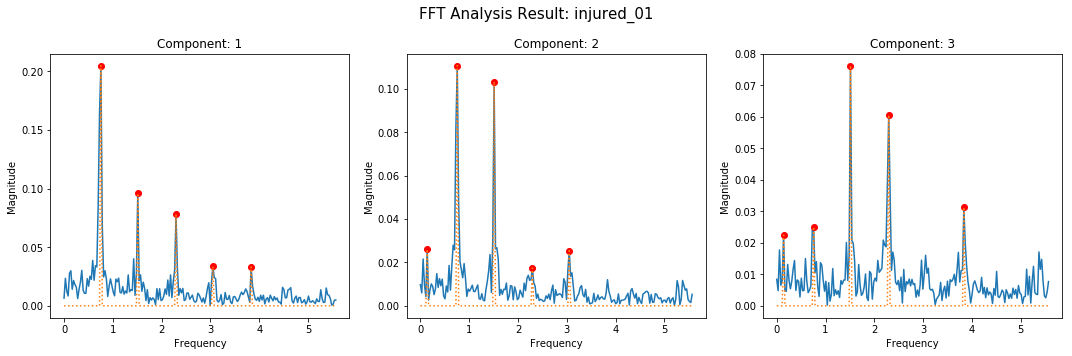

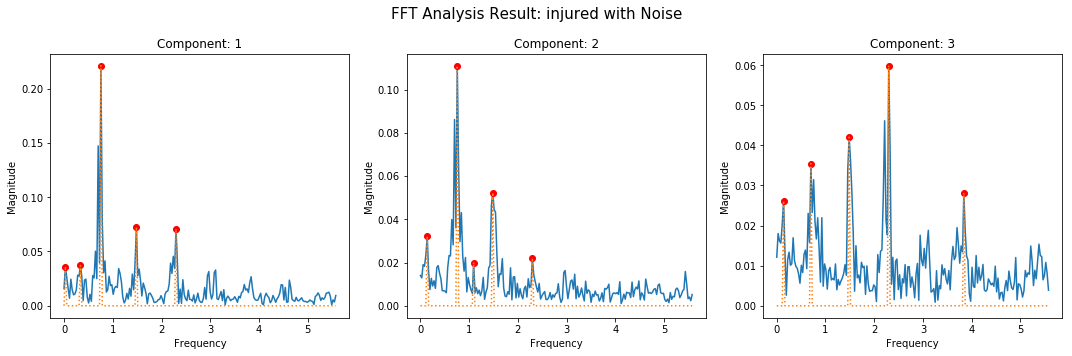

In [53]:
# Check the fft result of a no noise data and data from augmented data set with noise
VisFFTResult(test_in, test_case['Time'], cut_off_sig_len= cut_off, num_peaks= 5, data_name = test_case_name)
# test_case 1 same type data from augmented data set
name_same_type = test_case_name[:test_case_name.index("_")] 
aug_same_type = All_aug_data[name_same_type][0]
pca_same_type = PCA_all.applyRescalePCA(aug_same_type)
time_same_type = All_aug_data[name_same_type][0]['Time']
VisFFTResult(pca_same_type, time_same_type, cut_off_sig_len= cut_off, num_peaks= 5, data_name=name_same_type + " with Noise")

(0, 1)

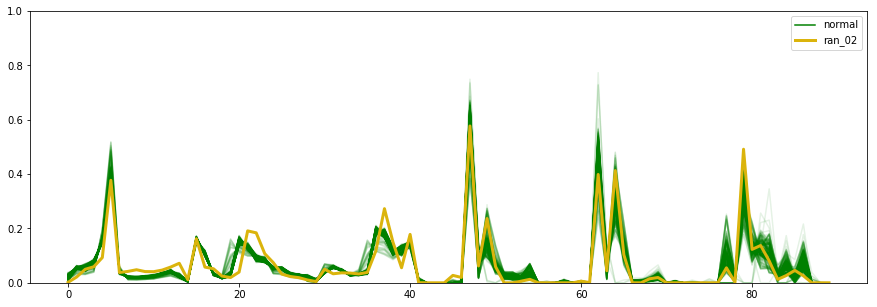

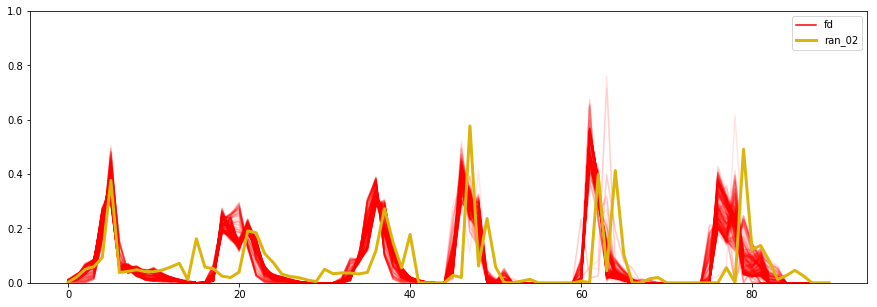

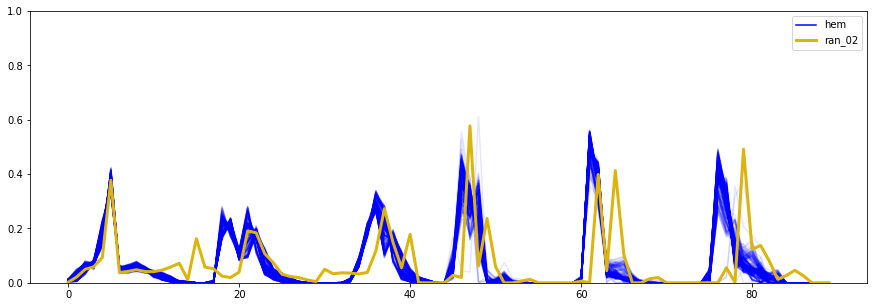

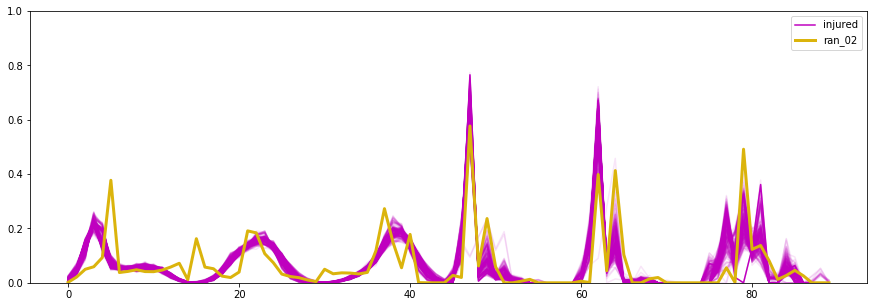

In [54]:
%matplotlib inline
vis_feature_trans = 0.1
num_same_type_sample = 300
plt.figure(figsize=(15,5))
for idx in range(3000,3000 + num_same_type_sample):
    plt.plot(train_matrix[idx,:], 'g-', alpha=vis_feature_trans)
plt.plot(train_matrix[idx,:], 'g-', label = gait_types[int(train_labels[idx])])
plt.plot(test_fea_2, 'xkcd:gold', linewidth=3.0, label = test_case_2_name)
plt.legend()
plt.ylim(0,1)


plt.figure(figsize=(15,5))
for idx in range(1500, 1500 + num_same_type_sample):
    plt.plot(train_matrix[idx,:], 'r-', alpha=vis_feature_trans)
plt.plot(train_matrix[idx,:], 'r-', label = gait_types[int(train_labels[idx])])
plt.plot(test_fea_2, 'xkcd:gold', linewidth=3.0, label = test_case_2_name)
plt.legend()
plt.ylim(0,1)


plt.figure(figsize=(15,5))
for idx in range(5000, 5000 + num_same_type_sample):
    plt.plot(train_matrix[idx,:], 'b-', alpha=vis_feature_trans)
plt.plot(train_matrix[idx,:], 'b-', label = gait_types[int(train_labels[idx])])
plt.plot(test_fea_2, 'xkcd:gold', linewidth=3.0, label = test_case_2_name)
plt.legend()
plt.ylim(0,1)


plt.figure(figsize=(15,5))
for idx in range(0, 0 + num_same_type_sample):
    plt.plot(train_matrix[idx,:], 'm-', alpha=vis_feature_trans)
plt.plot(train_matrix[idx,:], 'm-', label = gait_types[int(train_labels[idx])])
plt.plot(test_fea_2, 'xkcd:gold', linewidth=3.0, label = test_case_2_name)
plt.legend()
plt.ylim(0,1)

# plt.figure(figsize=(15,5))
# plt.plot(test_fea, label = test_case_name)
# plt.plot(test_fea_2, label = test_case_2_name)
# plt.ylim(0,1)
# plt.legend(loc = 0)
# plt.plot(train_matrix[2000,:])

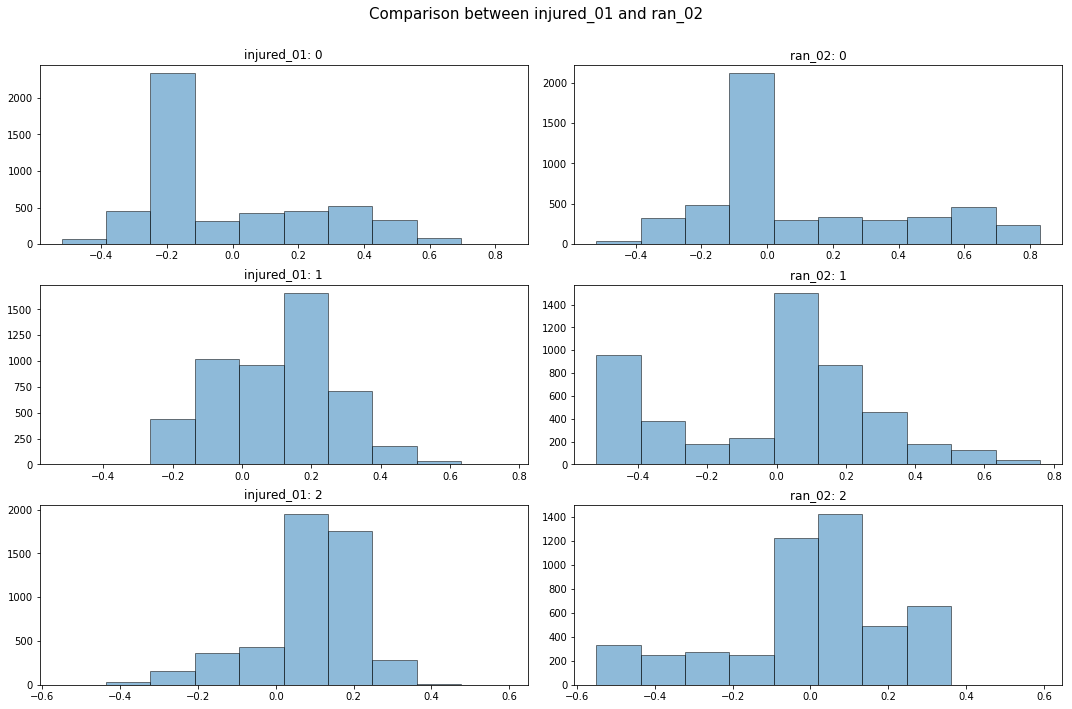

In [55]:
VisCompareTwoPCA(test_in, test_in_2, PCA_all, test_case_name, test_case_2_name)

In [56]:
print('Log')
print(test_log.predict_proba([test_fea]))
print(test_log.predict_proba([test_fea_2]))
print('SVM')
print(test_svc.predict_proba([test_fea]))
print(test_svc.predict_proba([test_fea_2]))
print('Ada')
print(test_ada.predict_proba([test_fea]))
print(test_ada.predict_proba([test_fea_2]))

Log
[[2.56283914e-02 1.77362859e-04 7.87882645e-03 9.66315419e-01]]
[[9.58241513e-01 5.07914322e-04 1.41382861e-02 2.71122867e-02]]
SVM
[[2.27518807e-07 1.29226631e-07 8.69995966e-08 9.99999556e-01]]
[[9.97760621e-01 2.28126475e-04 2.27916352e-04 1.78333620e-03]]
Ada
[[3.13921083e-11 4.73471551e-03 4.73471551e-03 9.90530569e-01]]
[[9.99953259e-01 2.33705693e-05 2.33705693e-05 4.92497977e-13]]
